In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [2]:
file = "Entrenamieto_ECI_2020.csv"
data = pd.read_csv(file)
data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [3]:
borrar = ["Opportunity_Name", "ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF"]
useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]
clear = ["Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Modified_Date", "Product_Type", 
         "Opportunity_Created_Date", "Quote_Type", "Account_Created_Date"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [4]:
def preprocess(data):
    
    # elimino caracteres prohibidos
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    # Contacts: la cantidad de negociaciones registradas
    # Delivery_difference: la cantidad de dias entre las fechas planeadas final e inicial de delivery
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform('count')
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2    
    
    # limpio columnas
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
    
    data = data.drop(borrar + useless + dates, axis = 1)    
    
    return (data)

In [5]:
df = preprocess(data)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)
categorical = ['Region', 'Territory', 'Bureaucratic_Code', 'Source', 'Billing_Country', 'Account_Name', 
               'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Last_Modified_By',
               'Opportunity_Type', 'Quote_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size',
               'Product_Category_B', 'Price', 'Currency', 'Last_Activity', 'Product_Family', 
               'Product_Name', 'ASP_Currency', 'ASP_converted_Currency', 'Month', 'Delivery_Quarter', 
               'Actual_Delivery_Date', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Prod_Category_A']
categorical = [x for x in categorical if x in df.columns]

In [32]:
train_data = lgb.Dataset(x_train.drop(target, axis = 1), label = y_train, categorical_feature = categorical)
test_data = lgb.Dataset(x_test.drop(target, axis = 1), label = y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.025,
    'max_bin': 400,
    'verbose': 0
}

model = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

[1]	valid_0's binary_logloss: 0.66504
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.652997
[3]	valid_0's binary_logloss: 0.641007
[4]	valid_0's binary_logloss: 0.630385
[5]	valid_0's binary_logloss: 0.611544
[6]	valid_0's binary_logloss: 0.593772
[7]	valid_0's binary_logloss: 0.576728
[8]	valid_0's binary_logloss: 0.560407
[9]	valid_0's binary_logloss: 0.544869
[10]	valid_0's binary_logloss: 0.529961
[11]	valid_0's binary_logloss: 0.521804
[12]	valid_0's binary_logloss: 0.507818
[13]	valid_0's binary_logloss: 0.494556
[14]	valid_0's binary_logloss: 0.481892
[15]	valid_0's binary_logloss: 0.46964
[16]	valid_0's binary_logloss: 0.46417
[17]	valid_0's binary_logloss: 0.452533
[18]	valid_0's binary_logloss: 0.446719
[19]	valid_0's binary_logloss: 0.435949
[20]	valid_0's binary_logloss: 0.430661
[21]	valid_0's binary_logloss: 0.420196
[22]	valid_0's binary_logloss: 0.414786
[23]	valid_0's binary_logloss: 0.404945
[24]	valid_0's binary_logloss:

[210]	valid_0's binary_logloss: 0.09415
[211]	valid_0's binary_logloss: 0.0938196
[212]	valid_0's binary_logloss: 0.0935231
[213]	valid_0's binary_logloss: 0.093356
[214]	valid_0's binary_logloss: 0.0930892
[215]	valid_0's binary_logloss: 0.0928466
[216]	valid_0's binary_logloss: 0.0926768
[217]	valid_0's binary_logloss: 0.0924571
[218]	valid_0's binary_logloss: 0.0922959
[219]	valid_0's binary_logloss: 0.0921538
[220]	valid_0's binary_logloss: 0.0921181
[221]	valid_0's binary_logloss: 0.0918531
[222]	valid_0's binary_logloss: 0.0917118
[223]	valid_0's binary_logloss: 0.0914835
[224]	valid_0's binary_logloss: 0.0913801
[225]	valid_0's binary_logloss: 0.0912305
[226]	valid_0's binary_logloss: 0.0910688
[227]	valid_0's binary_logloss: 0.0908646
[228]	valid_0's binary_logloss: 0.090656
[229]	valid_0's binary_logloss: 0.090538
[230]	valid_0's binary_logloss: 0.0903111
[231]	valid_0's binary_logloss: 0.0901198
[232]	valid_0's binary_logloss: 0.0899498
[233]	valid_0's binary_logloss: 0.08987

[420]	valid_0's binary_logloss: 0.074811
[421]	valid_0's binary_logloss: 0.0747899
[422]	valid_0's binary_logloss: 0.0747899
[423]	valid_0's binary_logloss: 0.0747601
[424]	valid_0's binary_logloss: 0.0747019
[425]	valid_0's binary_logloss: 0.0746414
[426]	valid_0's binary_logloss: 0.0746798
[427]	valid_0's binary_logloss: 0.0746175
[428]	valid_0's binary_logloss: 0.0745635
[429]	valid_0's binary_logloss: 0.0745343
[430]	valid_0's binary_logloss: 0.0744847
[431]	valid_0's binary_logloss: 0.0745357
[432]	valid_0's binary_logloss: 0.0745135
[433]	valid_0's binary_logloss: 0.0744922
[434]	valid_0's binary_logloss: 0.0744282
[435]	valid_0's binary_logloss: 0.0744084
[436]	valid_0's binary_logloss: 0.0743693
[437]	valid_0's binary_logloss: 0.0743458
[438]	valid_0's binary_logloss: 0.0743049
[439]	valid_0's binary_logloss: 0.0742578
[440]	valid_0's binary_logloss: 0.0742604
[441]	valid_0's binary_logloss: 0.0742893
[442]	valid_0's binary_logloss: 0.0742553
[443]	valid_0's binary_logloss: 0.0

[632]	valid_0's binary_logloss: 0.0726931
[633]	valid_0's binary_logloss: 0.0726043
[634]	valid_0's binary_logloss: 0.0725647
[635]	valid_0's binary_logloss: 0.0725435
[636]	valid_0's binary_logloss: 0.0725133
[637]	valid_0's binary_logloss: 0.0724982
[638]	valid_0's binary_logloss: 0.0724765
[639]	valid_0's binary_logloss: 0.0724703
[640]	valid_0's binary_logloss: 0.072479
[641]	valid_0's binary_logloss: 0.0724843
[642]	valid_0's binary_logloss: 0.0724673
[643]	valid_0's binary_logloss: 0.0724811
[644]	valid_0's binary_logloss: 0.0724527
[645]	valid_0's binary_logloss: 0.0725035
[646]	valid_0's binary_logloss: 0.0724345
[647]	valid_0's binary_logloss: 0.0724548
[648]	valid_0's binary_logloss: 0.0724841
[649]	valid_0's binary_logloss: 0.0725269
[650]	valid_0's binary_logloss: 0.0725098
[651]	valid_0's binary_logloss: 0.0724916
[652]	valid_0's binary_logloss: 0.0724581
[653]	valid_0's binary_logloss: 0.0724832
[654]	valid_0's binary_logloss: 0.0724755
[655]	valid_0's binary_logloss: 0.0

[836]	valid_0's binary_logloss: 0.0731996
[837]	valid_0's binary_logloss: 0.0732328
[838]	valid_0's binary_logloss: 0.0732195
[839]	valid_0's binary_logloss: 0.0732684
[840]	valid_0's binary_logloss: 0.0733204
[841]	valid_0's binary_logloss: 0.0733763
[842]	valid_0's binary_logloss: 0.0734358
[843]	valid_0's binary_logloss: 0.0734533
[844]	valid_0's binary_logloss: 0.0734787
[845]	valid_0's binary_logloss: 0.0735304
[846]	valid_0's binary_logloss: 0.0735739
[847]	valid_0's binary_logloss: 0.0735495
[848]	valid_0's binary_logloss: 0.0735341
[849]	valid_0's binary_logloss: 0.0735764
[850]	valid_0's binary_logloss: 0.0735975
[851]	valid_0's binary_logloss: 0.0736588
[852]	valid_0's binary_logloss: 0.073683
[853]	valid_0's binary_logloss: 0.0737168
[854]	valid_0's binary_logloss: 0.0737624
[855]	valid_0's binary_logloss: 0.0737663
[856]	valid_0's binary_logloss: 0.0737752
[857]	valid_0's binary_logloss: 0.0738405
[858]	valid_0's binary_logloss: 0.0738719
[859]	valid_0's binary_logloss: 0.0

[1046]	valid_0's binary_logloss: 0.076738
[1047]	valid_0's binary_logloss: 0.0767735
[1048]	valid_0's binary_logloss: 0.0767827
[1049]	valid_0's binary_logloss: 0.0767975
[1050]	valid_0's binary_logloss: 0.0768147
[1051]	valid_0's binary_logloss: 0.0768377
[1052]	valid_0's binary_logloss: 0.0768661
[1053]	valid_0's binary_logloss: 0.0768494
[1054]	valid_0's binary_logloss: 0.0768445
[1055]	valid_0's binary_logloss: 0.07684
[1056]	valid_0's binary_logloss: 0.0768147
[1057]	valid_0's binary_logloss: 0.0768078
[1058]	valid_0's binary_logloss: 0.0767611
[1059]	valid_0's binary_logloss: 0.0767535
[1060]	valid_0's binary_logloss: 0.0767523
[1061]	valid_0's binary_logloss: 0.0767774
[1062]	valid_0's binary_logloss: 0.0768279
[1063]	valid_0's binary_logloss: 0.0768836
[1064]	valid_0's binary_logloss: 0.07692
[1065]	valid_0's binary_logloss: 0.0769859
[1066]	valid_0's binary_logloss: 0.0770331
[1067]	valid_0's binary_logloss: 0.0770282
[1068]	valid_0's binary_logloss: 0.0770762
[1069]	valid_0's

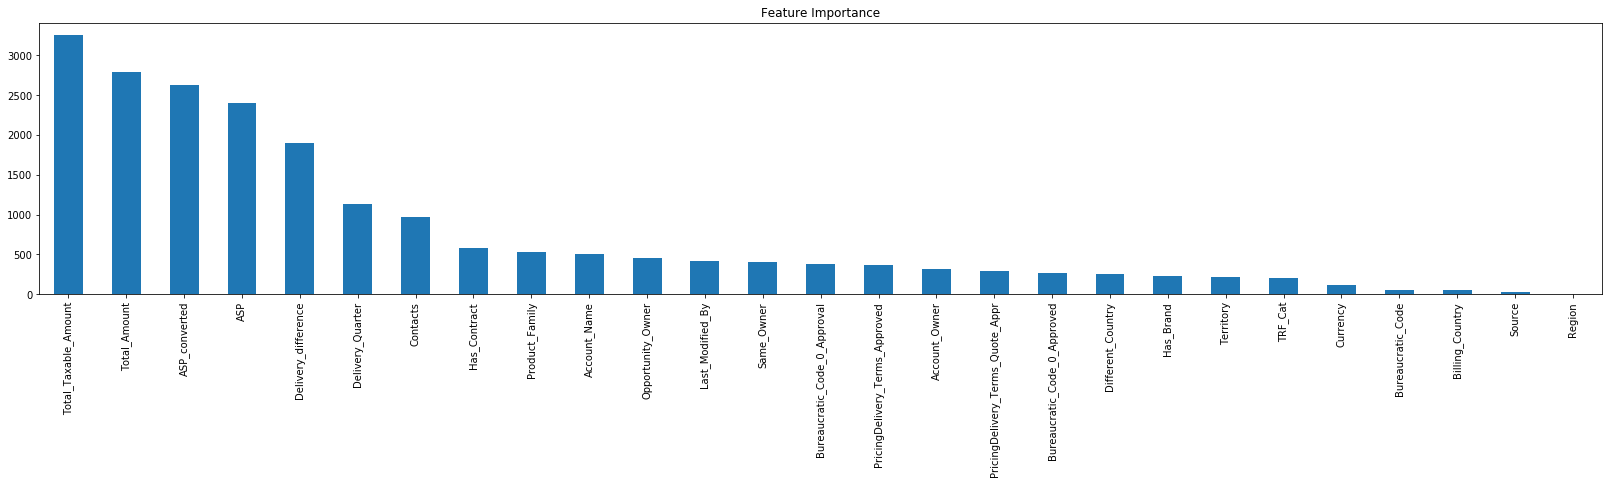

In [14]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importance(), predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

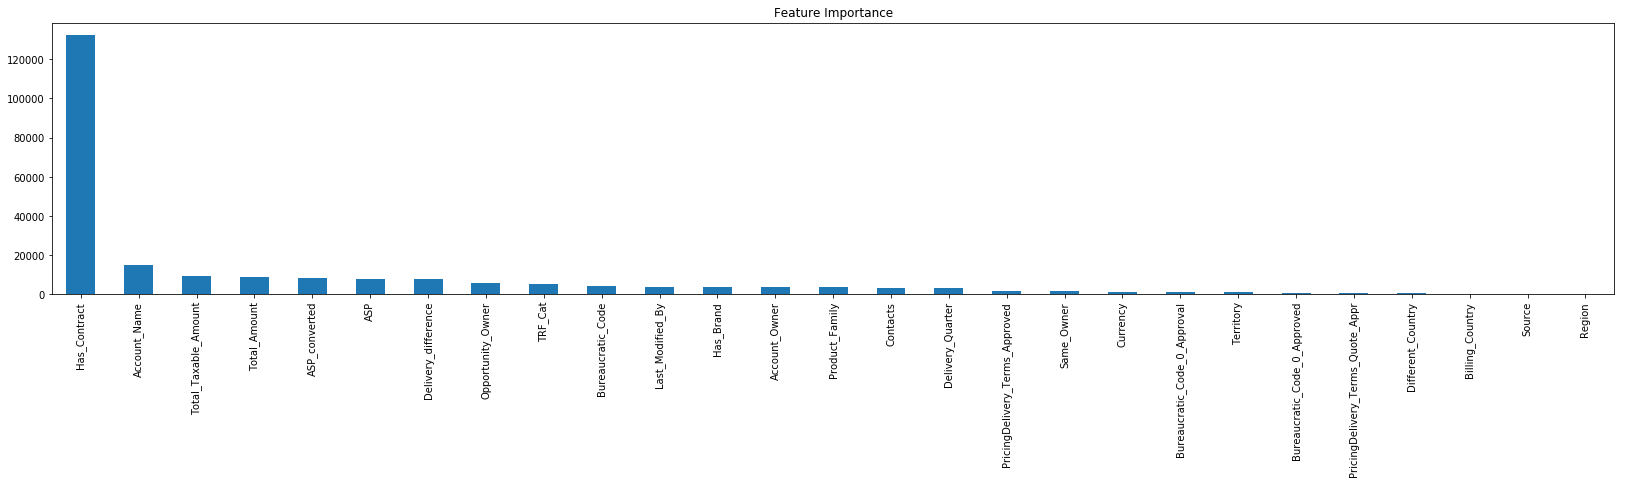

In [15]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importance("gain"), predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [38]:
print feat_imp

Has_Contract                        132189.831204
Account_Name                         14944.195275
Total_Taxable_Amount                  9285.856698
Total_Amount                          8958.850211
ASP_converted                         8119.464227
ASP                                   7923.161328
Delivery_difference                   7805.403543
Opportunity_Owner                     5753.063031
TRF_Cat                               5262.649128
Bureaucratic_Code                     4434.863865
Last_Modified_By                      3814.109111
Has_Brand                             3792.375400
Account_Owner                         3493.268516
Product_Family                        3485.746870
Contacts                              3467.743982
Delivery_Quarter                      3093.455826
PricingDelivery_Terms_Approved        1833.935392
Same_Owner                            1739.691186
Currency                              1227.312579
Bureaucratic_Code_0_Approval          1191.129395


In [33]:
y_pred = model.predict(x_test.drop(target, axis = 1))
pred = pd.DataFrame(y_pred, index = x_test.index, columns = ["Prediction"])
x_test = x_test.join(pred)
answer = x_test.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [34]:
log_loss(answer["Stage"], answer["Prediction"])

0.0825364128344408

In [35]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)

In [36]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
prev = pd.read_csv("submission1.csv")
prev["Prediction"].corr(answer["Prediction"])

0.9921577738928584

In [64]:
df_only = df[df.Contacts == 1]

In [65]:
df_several = df[df.Contacts > 1]

In [69]:
x_train_only, x_test_only, y_train_only, y_test_only = train_test_split(df_only, df_only.Stage, test_size = 0.3, random_state = 0)
x_train_several, x_test_several, y_train_several, y_test_several = train_test_split(df_several, df_several.Stage, test_size = 0.3, random_state = 0)
x_train, x_test, y_train, y_test = pd.concat([x_train_only, x_train_several]), pd.concat([x_test_only, x_test_several]), pd.concat([y_train_only, y_train_several]), pd.concat([y_test_only, y_test_several])

In [70]:
categorical = ['Region', 'Territory', 'Bureaucratic_Code', 'Source', 'Billing_Country', 'Account_Name', 
               'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Last_Modified_By',
               'Opportunity_Type', 'Quote_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size',
               'Product_Category_B', 'Price', 'Currency', 'Last_Activity', 'Product_Family', 
               'Product_Name', 'ASP_Currency', 'ASP_converted_Currency', 'Month', 'Delivery_Quarter', 
               'Actual_Delivery_Date', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Prod_Category_A']
categorical = [x for x in categorical if x in df.columns]

train_data = lgb.Dataset(x_train.drop(target, axis = 1), label = y_train, categorical_feature = categorical)
test_data = lgb.Dataset(x_test.drop(target, axis = 1), label = y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.025,
    'max_bin': 400,
    'verbose': 0
}

model = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

[1]	valid_0's binary_logloss: 0.673105
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.662341
[3]	valid_0's binary_logloss: 0.650952
[4]	valid_0's binary_logloss: 0.640958
[5]	valid_0's binary_logloss: 0.630855
[6]	valid_0's binary_logloss: 0.621747
[7]	valid_0's binary_logloss: 0.612511
[8]	valid_0's binary_logloss: 0.603677
[9]	valid_0's binary_logloss: 0.595522
[10]	valid_0's binary_logloss: 0.586524
[11]	valid_0's binary_logloss: 0.578067
[12]	valid_0's binary_logloss: 0.570507
[13]	valid_0's binary_logloss: 0.562839
[14]	valid_0's binary_logloss: 0.555838
[15]	valid_0's binary_logloss: 0.548894
[16]	valid_0's binary_logloss: 0.542113
[17]	valid_0's binary_logloss: 0.535385
[18]	valid_0's binary_logloss: 0.528487
[19]	valid_0's binary_logloss: 0.523522
[20]	valid_0's binary_logloss: 0.517018
[21]	valid_0's binary_logloss: 0.511121
[22]	valid_0's binary_logloss: 0.506607
[23]	valid_0's binary_logloss: 0.502524
[24]	valid_0's binary_loglo

[203]	valid_0's binary_logloss: 0.265228
[204]	valid_0's binary_logloss: 0.264868
[205]	valid_0's binary_logloss: 0.264446
[206]	valid_0's binary_logloss: 0.264165
[207]	valid_0's binary_logloss: 0.263977
[208]	valid_0's binary_logloss: 0.263733
[209]	valid_0's binary_logloss: 0.263515
[210]	valid_0's binary_logloss: 0.263185
[211]	valid_0's binary_logloss: 0.262961
[212]	valid_0's binary_logloss: 0.262636
[213]	valid_0's binary_logloss: 0.262437
[214]	valid_0's binary_logloss: 0.262088
[215]	valid_0's binary_logloss: 0.261676
[216]	valid_0's binary_logloss: 0.26134
[217]	valid_0's binary_logloss: 0.261089
[218]	valid_0's binary_logloss: 0.260981
[219]	valid_0's binary_logloss: 0.260659
[220]	valid_0's binary_logloss: 0.260394
[221]	valid_0's binary_logloss: 0.260084
[222]	valid_0's binary_logloss: 0.259906
[223]	valid_0's binary_logloss: 0.259539
[224]	valid_0's binary_logloss: 0.259299
[225]	valid_0's binary_logloss: 0.259034
[226]	valid_0's binary_logloss: 0.25885
[227]	valid_0's bi

[434]	valid_0's binary_logloss: 0.231062
[435]	valid_0's binary_logloss: 0.231081
[436]	valid_0's binary_logloss: 0.231097
[437]	valid_0's binary_logloss: 0.231124
[438]	valid_0's binary_logloss: 0.23107
[439]	valid_0's binary_logloss: 0.231059
[440]	valid_0's binary_logloss: 0.231034
[441]	valid_0's binary_logloss: 0.230881
[442]	valid_0's binary_logloss: 0.230791
[443]	valid_0's binary_logloss: 0.23066
[444]	valid_0's binary_logloss: 0.230459
[445]	valid_0's binary_logloss: 0.230283
[446]	valid_0's binary_logloss: 0.230218
[447]	valid_0's binary_logloss: 0.230115
[448]	valid_0's binary_logloss: 0.229895
[449]	valid_0's binary_logloss: 0.229799
[450]	valid_0's binary_logloss: 0.229652
[451]	valid_0's binary_logloss: 0.229451
[452]	valid_0's binary_logloss: 0.22936
[453]	valid_0's binary_logloss: 0.229296
[454]	valid_0's binary_logloss: 0.229248
[455]	valid_0's binary_logloss: 0.229133
[456]	valid_0's binary_logloss: 0.228964
[457]	valid_0's binary_logloss: 0.228822
[458]	valid_0's bin

[649]	valid_0's binary_logloss: 0.216954
[650]	valid_0's binary_logloss: 0.21684
[651]	valid_0's binary_logloss: 0.216751
[652]	valid_0's binary_logloss: 0.216671
[653]	valid_0's binary_logloss: 0.21665
[654]	valid_0's binary_logloss: 0.216636
[655]	valid_0's binary_logloss: 0.21662
[656]	valid_0's binary_logloss: 0.21663
[657]	valid_0's binary_logloss: 0.216626
[658]	valid_0's binary_logloss: 0.216561
[659]	valid_0's binary_logloss: 0.216526
[660]	valid_0's binary_logloss: 0.216468
[661]	valid_0's binary_logloss: 0.216411
[662]	valid_0's binary_logloss: 0.21642
[663]	valid_0's binary_logloss: 0.216325
[664]	valid_0's binary_logloss: 0.216358
[665]	valid_0's binary_logloss: 0.216331
[666]	valid_0's binary_logloss: 0.216276
[667]	valid_0's binary_logloss: 0.216257
[668]	valid_0's binary_logloss: 0.216208
[669]	valid_0's binary_logloss: 0.216192
[670]	valid_0's binary_logloss: 0.216135
[671]	valid_0's binary_logloss: 0.216129
[672]	valid_0's binary_logloss: 0.216094
[673]	valid_0's binar

[892]	valid_0's binary_logloss: 0.208972
[893]	valid_0's binary_logloss: 0.208887
[894]	valid_0's binary_logloss: 0.208869
[895]	valid_0's binary_logloss: 0.208853
[896]	valid_0's binary_logloss: 0.208821
[897]	valid_0's binary_logloss: 0.208794
[898]	valid_0's binary_logloss: 0.208744
[899]	valid_0's binary_logloss: 0.20871
[900]	valid_0's binary_logloss: 0.208701
[901]	valid_0's binary_logloss: 0.208679
[902]	valid_0's binary_logloss: 0.208544
[903]	valid_0's binary_logloss: 0.20861
[904]	valid_0's binary_logloss: 0.208614
[905]	valid_0's binary_logloss: 0.208569
[906]	valid_0's binary_logloss: 0.208595
[907]	valid_0's binary_logloss: 0.208507
[908]	valid_0's binary_logloss: 0.208476
[909]	valid_0's binary_logloss: 0.20854
[910]	valid_0's binary_logloss: 0.208562
[911]	valid_0's binary_logloss: 0.208619
[912]	valid_0's binary_logloss: 0.208623
[913]	valid_0's binary_logloss: 0.208494
[914]	valid_0's binary_logloss: 0.208536
[915]	valid_0's binary_logloss: 0.208549
[916]	valid_0's bin

[1095]	valid_0's binary_logloss: 0.208731
[1096]	valid_0's binary_logloss: 0.208752
[1097]	valid_0's binary_logloss: 0.208759
[1098]	valid_0's binary_logloss: 0.208874
[1099]	valid_0's binary_logloss: 0.208912
[1100]	valid_0's binary_logloss: 0.208893
[1101]	valid_0's binary_logloss: 0.208911
[1102]	valid_0's binary_logloss: 0.208918
[1103]	valid_0's binary_logloss: 0.208903
[1104]	valid_0's binary_logloss: 0.208854
[1105]	valid_0's binary_logloss: 0.208844
[1106]	valid_0's binary_logloss: 0.208796
[1107]	valid_0's binary_logloss: 0.208723
[1108]	valid_0's binary_logloss: 0.208702
[1109]	valid_0's binary_logloss: 0.208625
[1110]	valid_0's binary_logloss: 0.208589
[1111]	valid_0's binary_logloss: 0.208567
[1112]	valid_0's binary_logloss: 0.208529
[1113]	valid_0's binary_logloss: 0.208532
[1114]	valid_0's binary_logloss: 0.208493
[1115]	valid_0's binary_logloss: 0.208469
[1116]	valid_0's binary_logloss: 0.208477
[1117]	valid_0's binary_logloss: 0.208456
[1118]	valid_0's binary_logloss: 0

[1302]	valid_0's binary_logloss: 0.207861
[1303]	valid_0's binary_logloss: 0.2079
[1304]	valid_0's binary_logloss: 0.20787
[1305]	valid_0's binary_logloss: 0.207874
[1306]	valid_0's binary_logloss: 0.207818
[1307]	valid_0's binary_logloss: 0.207764
[1308]	valid_0's binary_logloss: 0.207775
[1309]	valid_0's binary_logloss: 0.207751
[1310]	valid_0's binary_logloss: 0.207834
[1311]	valid_0's binary_logloss: 0.207796
[1312]	valid_0's binary_logloss: 0.207775
[1313]	valid_0's binary_logloss: 0.207801
[1314]	valid_0's binary_logloss: 0.207798
[1315]	valid_0's binary_logloss: 0.20782
[1316]	valid_0's binary_logloss: 0.207844
[1317]	valid_0's binary_logloss: 0.207831
[1318]	valid_0's binary_logloss: 0.207791
[1319]	valid_0's binary_logloss: 0.2078
[1320]	valid_0's binary_logloss: 0.207791
[1321]	valid_0's binary_logloss: 0.207745
[1322]	valid_0's binary_logloss: 0.207693
[1323]	valid_0's binary_logloss: 0.207654
[1324]	valid_0's binary_logloss: 0.207551
[1325]	valid_0's binary_logloss: 0.20761

[1542]	valid_0's binary_logloss: 0.207022
[1543]	valid_0's binary_logloss: 0.206999
[1544]	valid_0's binary_logloss: 0.206917
[1545]	valid_0's binary_logloss: 0.206927
[1546]	valid_0's binary_logloss: 0.206893
[1547]	valid_0's binary_logloss: 0.20691
[1548]	valid_0's binary_logloss: 0.20692
[1549]	valid_0's binary_logloss: 0.20694
[1550]	valid_0's binary_logloss: 0.206931
[1551]	valid_0's binary_logloss: 0.20688
[1552]	valid_0's binary_logloss: 0.206914
[1553]	valid_0's binary_logloss: 0.206903
[1554]	valid_0's binary_logloss: 0.206923
[1555]	valid_0's binary_logloss: 0.20689
[1556]	valid_0's binary_logloss: 0.206883
[1557]	valid_0's binary_logloss: 0.206896
[1558]	valid_0's binary_logloss: 0.206947
[1559]	valid_0's binary_logloss: 0.206954
[1560]	valid_0's binary_logloss: 0.206971
[1561]	valid_0's binary_logloss: 0.20699
[1562]	valid_0's binary_logloss: 0.207032
[1563]	valid_0's binary_logloss: 0.207057
[1564]	valid_0's binary_logloss: 0.207093
[1565]	valid_0's binary_logloss: 0.20711

[1775]	valid_0's binary_logloss: 0.209911
[1776]	valid_0's binary_logloss: 0.209885
[1777]	valid_0's binary_logloss: 0.20988
[1778]	valid_0's binary_logloss: 0.209895
[1779]	valid_0's binary_logloss: 0.209909
[1780]	valid_0's binary_logloss: 0.209859
[1781]	valid_0's binary_logloss: 0.209877
[1782]	valid_0's binary_logloss: 0.209816
[1783]	valid_0's binary_logloss: 0.209817
[1784]	valid_0's binary_logloss: 0.209814
[1785]	valid_0's binary_logloss: 0.209801
[1786]	valid_0's binary_logloss: 0.209816
[1787]	valid_0's binary_logloss: 0.209791
[1788]	valid_0's binary_logloss: 0.209756
[1789]	valid_0's binary_logloss: 0.209727
[1790]	valid_0's binary_logloss: 0.209692
[1791]	valid_0's binary_logloss: 0.209713
[1792]	valid_0's binary_logloss: 0.209706
[1793]	valid_0's binary_logloss: 0.209736
[1794]	valid_0's binary_logloss: 0.209793
[1795]	valid_0's binary_logloss: 0.20977
[1796]	valid_0's binary_logloss: 0.209772
[1797]	valid_0's binary_logloss: 0.209777
[1798]	valid_0's binary_logloss: 0.2

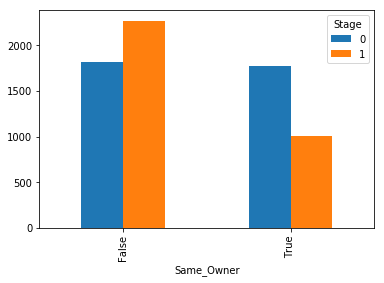

In [12]:
pd.crosstab(df_only.Same_Owner, df_only.Stage).plot(kind = "bar")

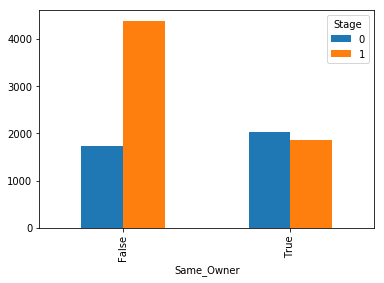

In [14]:
pd.crosstab(df_several.Same_Owner, df_several.Stage).plot(kind = "bar")

In [16]:
df_only.groupby("Stage")["Stage"].count()

Stage
0    3601
1    3281
Name: Stage, dtype: int64

In [17]:
df_several.groupby("Stage")["Stage"].count()

Stage
0    3749
1    6252
Name: Stage, dtype: int64

In [30]:
data[(data.Billing_Country != data.Territory) & (data.Territory != "None")].groupby("Stage")["Stage"].count()

Stage
0    2323
1    2225
Name: Stage, dtype: int64

In [31]:
data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")

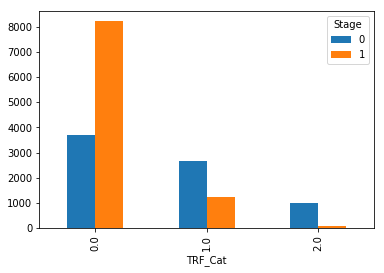

In [34]:
pd.crosstab(data.TRF_Cat, data.Stage).plot(kind = "bar")

In [74]:
df_several

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Account_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,Product_Family,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_difference,Same_Owner,Has_Brand,Different_Country,TRF_Cat
8,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,Account_Name_1888,8,None,Person_Name_50,Person_Name_50,None,Person_Name_50,Product_Family_6,NaN,NaN,Q1,15600.00,470400.00,0,5,0.0,True,False,False,0.0
9,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,Account_Name_1888,8,None,Person_Name_50,Person_Name_50,None,Person_Name_50,Product_Family_4,NaN,NaN,Q1,4400.00,470400.00,0,5,0.0,True,False,False,0.0
10,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,Account_Name_1888,8,None,Person_Name_50,Person_Name_50,None,Person_Name_50,Product_Family_226,NaN,NaN,Q1,6200.00,470400.00,0,5,0.0,True,False,False,0.0
11,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,Account_Name_1888,8,None,Person_Name_50,Person_Name_50,None,Person_Name_50,Product_Family_23,NaN,NaN,Q1,140000.00,470400.00,0,5,0.0,True,False,False,0.0
12,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,Account_Name_1888,8,None,Person_Name_50,Person_Name_50,None,Person_Name_50,Product_Family_77,78.000,0.70125,Q1,304200.00,470400.00,0,5,0.0,True,False,False,0.0
13,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,Account_Name_1888,9,None,Person_Name_50,Person_Name_50,None,Person_Name_50,Product_Family_6,NaN,NaN,Q1,23400.00,559320.00,0,5,0.0,True,False,False,0.0
14,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,Account_Name_1888,9,None,Person_Name_50,Person_Name_50,None,Person_Name_50,Product_Family_4,NaN,NaN,Q1,4400.00,559320.00,0,5,0.0,True,False,False,0.0
15,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,Account_Name_1888,9,None,Person_Name_50,Person_Name_50,None,Person_Name_50,Product_Family_226,NaN,NaN,Q1,6200.00,559320.00,0,5,0.0,True,False,False,0.0
16,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,Account_Name_1888,9,None,Person_Name_50,Person_Name_50,None,Person_Name_50,Product_Family_23,NaN,NaN,Q1,140000.00,559320.00,0,5,0.0,True,False,False,0.0
17,Japan,None,1,0,0,0,Bureaucratic_Code_5,None,Japan,Account_Name_1888,9,None,Person_Name_50,Person_Name_50,None,Person_Name_50,Product_Family_77,78.000,0.70125,Q1,385320.00,559320.00,0,5,0.0,True,False,False,0.0


In [7]:
df.groupby("Sales_Contract_No")["Sales_Contract_No"].count()

Sales_Contract_No
0          1
1          1
10         1
100        7
1000       1
1001       2
1002       1
1003       5
1004       5
1005       5
1006       5
1007       5
1008       1
1009       1
101        1
1010       2
1011       1
1012       1
1013       2
1014       1
1015       2
1016       2
1017       1
1018       2
1019       3
102        1
1020       1
1021       2
1022       1
1023       2
1024       2
1025       1
1026       2
1027       1
1028       2
1029       2
103        1
1030       2
1031       1
1032       1
1033       1
1034       1
1035       2
1036       1
1037       1
1038       1
1039       1
104        1
1040       1
1041       1
        ... 
954        2
955        1
956        1
958        1
959        1
96         1
960        1
961        1
962        1
963        1
964        1
965        1
966        1
967        1
968        1
969        1
97         3
970        1
971        1
972        1
973        1
974        1
975        1
976        2
977    

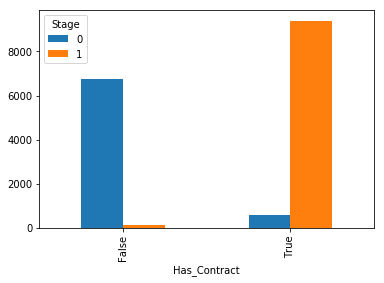

In [7]:
pd.crosstab(df.Has_Contract, df.Stage).plot(kind = "bar")

In [25]:
categorical = ['Region', 'Territory', 'Bureaucratic_Code', 'Source', 'Billing_Country', 'Account_Name', 
               'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Last_Modified_By',
               'Opportunity_Type', 'Quote_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size',
               'Product_Category_B', 'Price', 'Currency', 'Last_Activity', 'Product_Family', 
               'Product_Name', 'ASP_Currency', 'ASP_converted_Currency', 'Month', 'Delivery_Quarter', 
               'Actual_Delivery_Date', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Prod_Category_A']
categorical = [x for x in categorical if x in df.columns]

full_data = lgb.Dataset(df.drop(target, axis = 1), label = df.Stage, categorical_feature = categorical)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.025,
    'max_bin': 400,
    'verbose': 0
}

full_model = lgb.train(parameters, full_data, num_boost_round = 5000)

In [26]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = full_model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
prev = pd.read_csv("submission1.csv")
prev["Prediction"].corr(answer["Prediction"])

0.9860515309173146

In [37]:
answer.to_csv("submission_7.csv", header = False, index = False)

In [9]:
data.Product_Name.value_counts()

Product_Name_100    976
Product_Name_226    836
Product_Name_231    577
Product_Name_491    524
Product_Name_4      474
Product_Name_192    442
Product_Name_111    388
Product_Name_132    383
Product_Name_495    350
Product_Name_29     341
Product_Name_148    340
Product_Name_452    335
Product_Name_167    333
Product_Name_241    319
Product_Name_220    317
Product_Name_209    287
Product_Name_20     266
Product_Name_181    219
Product_Name_439    212
Product_Name_214    179
Product_Name_246    178
Product_Name_24     167
Product_Name_0      165
Product_Name_85     158
Product_Name_23     157
Product_Name_96     145
Product_Name_99     127
Product_Name_448    127
Product_Name_128    122
Product_Name_6      121
Product_Name_435    120
Product_Name_10     116
Product_Name_310    116
Product_Name_445    115
Product_Name_433    113
Product_Name_432    109
Product_Name_308    104
Product_Name_201    103
Product_Name_327    101
Product_Name_227    100
Product_Name_383     99
Product_Name_464